In [30]:
import pymolpro
import pandas as pd

In [31]:
backend = 'local' 
project_name = 'FH51_methodtest'
parallel = 8

In [32]:
methods = {"HF": "hf",
"MP2": "mp2",
"MP3": "mp3",
"MP4": "mp4",
"PAPT2":"PAPT;MP2",
"PAPT3":"PAPT;MP3",
"PAPT4":"PAPT;MP4",
"CCSD":"CCSD",
"CCSD(T)":"CCSD(T)" }
bases = ['cc-pVDZ','cc-pVTZ']

In [33]:
db = pymolpro.database.load("GMTKN55_FH51")

In [34]:
small=db.subset(open_shell=False,max_electrons=40)
print(small)

GMTKN55 FH51 (closed shell only) (maximum number of electrons 40):

Molecules:
H2O: {'geometry': '           3\n  \n    O         -1.09989026     -0.36122310      0.00000000\n    H         -0.12964877     -0.31792312      0.00000000\n    H         -1.38294827      0.56782190      0.00000000\n', 'description': 'H2O'}
1-pentene: {'geometry': '          15\n  \n    C         -3.68308053      0.94452211     -0.01656012\n    H         -3.68590013     -0.15545023      0.01932632\n    H         -3.15545960      1.24410275     -0.93472391\n    H         -4.72649383      1.27817511     -0.10830711\n    C         -3.01404275      1.53769362      1.22534673\n    H         -3.04848053      2.63830850      1.18144679\n    H         -3.58173640      1.25027510      2.12610967\n    C         -1.54958284      1.09017006      1.38850510\n    H         -1.52589130     -0.01495244      1.41907116\n    H         -0.96721377      1.39104970      0.50204330\n    C         -0.89999612      1.63188771      2.

In [35]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(small, methods[method], basis, location=project_name,
                                                       backend=backend,
                                                       preamble="core,small", parallel=parallel)
        if results[method][basis].failed: print(method, basis, 'failed', results[method][basis].project_directory)
        
print(results)    

{'HF': {'cc-pVDZ': <pymolpro.database.Database object at 0x7fef7b0b5b70>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7fef8a63f3a0>}, 'MP2': {'cc-pVDZ': <pymolpro.database.Database object at 0x7fef7b12ab00>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7fef7b0b6710>}, 'MP3': {'cc-pVDZ': <pymolpro.database.Database object at 0x7ff00bf160b0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7ff00be99720>}, 'MP4': {'cc-pVDZ': <pymolpro.database.Database object at 0x7fef7b0b61a0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7fef7b0b5510>}, 'PAPT2': {'cc-pVDZ': <pymolpro.database.Database object at 0x7fef7b0b4df0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7fef7b172b00>}, 'PAPT3': {'cc-pVDZ': <pymolpro.database.Database object at 0x7ff024a046a0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7fef7b0d9f30>}, 'PAPT4': {'cc-pVDZ': <pymolpro.database.Database object at 0x7ff024781660>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7fef7b0db8e0>}, 'CCSD':

In [36]:
analyse=pymolpro.database.analyse([result['cc-pVTZ'] for result in results.values()],small)
analyse['reaction statistics']

,HF/cc-pVTZ,MP2/cc-pVTZ,MP3/cc-pVTZ,MP4/cc-pVTZ,PAPT;MP2/cc-pVTZ,PAPT;MP3/cc-pVTZ,PAPT;MP4/cc-pVTZ,CCSD/cc-pVTZ,CCSD(T)/cc-pVTZ
MAD,0.001406,0.001451,0.002552,0.001011,0.002014,0.001963,0.001374,0.001436,0.001126
MAXD,0.002823,0.002750,0.005729,0.002652,0.004084,0.003969,0.002193,0.002499,0.002192
RMSD,0.001689,0.001763,0.003537,0.001323,0.002554,0.002486,0.001644,0.001719,0.001353
MSD,0.000961,0.001035,-0.002174,0.000717,-0.001395,-0.001339,-0.000509,-0.000656,-0.000249
STDEVD,0.001553,0.001596,0.003119,0.001244,0.002391,0.002342,0.001748,0.001777,0.001486


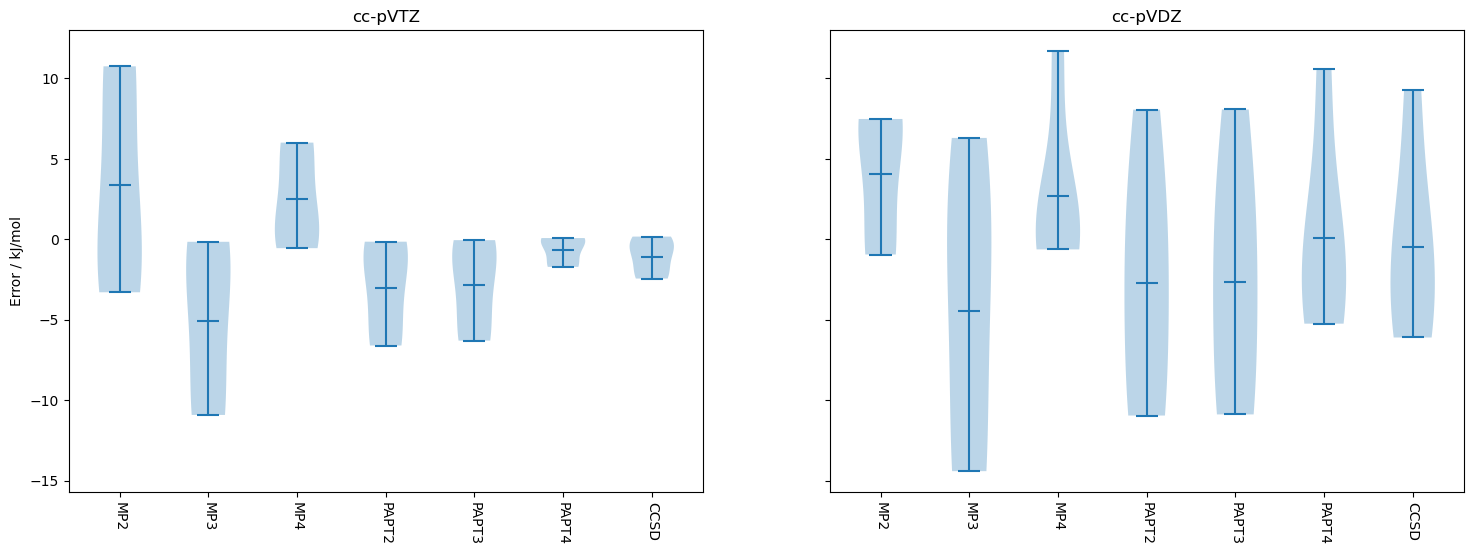

In [38]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if (method != 'HF') and (method != 'CCSD(T)')]
bases_pruned = ['cc-pVTZ', 'cc-pVDZ']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      results['CCSD(T)']['cc-pVTZ'],'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")


In [39]:
extrapolate=pymolpro.database.basis_extrapolate(results[method].values(), results["HF"].values())
extrapolate